# DistilBERT Fine-tuning

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import os
import warnings
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
os.makedirs("../models/distilbert_emotion_model", exist_ok=True)
os.makedirs("../results/models", exist_ok=True)
os.makedirs("../results/figures", exist_ok=True)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.9.1
CUDA available: False


Load Data

In [2]:
train_df = pd.read_csv("../data/processed/train_processed.csv")
val_df = pd.read_csv("../data/processed/val_processed.csv")
test_df = pd.read_csv("../data/processed/test_processed.csv")

print(f"Train: {train_df.shape} | Val: {val_df.shape} | Test: {test_df.shape}")


Train: (43362, 2) | Val: (5422, 2) | Test: (5423, 2)


Load Emotion Mapping

In [3]:
with open("../data/processed/emotion_mapping.json", "r") as f:
    emotion_mapping = json.load(f)

id_to_emotion = {int(k): v for k, v in emotion_mapping["id_to_emotion"].items()}
emotion_to_id = emotion_mapping["emotion_to_id"]
num_labels = len(emotion_to_id)

print(f"Number of classes: {num_labels}")
print("Emotion to ID mapping:")
for emotion, idx in emotion_to_id.items():
    print(f"  {emotion}: {idx}")


Number of classes: 7
Emotion to ID mapping:
  anger: 0
  disgust: 1
  fear: 2
  joy: 3
  neutral: 4
  sadness: 5
  surprise: 6


Prepare Data

In [4]:
X_train = train_df["text"].values
y_train = train_df["emotion"].map(emotion_to_id).values

X_val = val_df["text"].values
y_val = val_df["emotion"].map(emotion_to_id).values

X_test = test_df["text"].values
y_test = test_df["emotion"].map(emotion_to_id).values

print(f"Train: {len(X_train)} samples")
print(f"Val: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Train: 43362 samples
Val: 5422 samples
Test: 5423 samples


Initialize Model

In [5]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

print(f"Model: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: distilbert-base-uncased
Number of parameters: 66,958,855


Dataset Class

In [6]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }


Class Balancing

In [7]:
from collections import Counter
import random

emotion_counts = Counter(y_train)
print("Original class distribution:")
for emotion, idx in emotion_to_id.items():
    count = emotion_counts[idx]
    print(f"  {emotion:10s}: {count:6,} samples")

mean_samples = int(np.mean(list(emotion_counts.values())))
print(f"\nMean samples per class: {mean_samples:,}")
print(f"Imbalance ratio: {max(emotion_counts.values()) / min(emotion_counts.values()):.2f}:1")

print("\nBalancing classes to mean...")
print("  - Oversampling classes below mean (random duplication)")
print("  - Undersampling classes above mean")

random.seed(42)
np.random.seed(42)

X_train_balanced = []
y_train_balanced = []

for emotion, idx in emotion_to_id.items():
    class_indices = np.where(y_train == idx)[0]
    class_count = len(class_indices)
    
    if class_count < mean_samples:
        needed = mean_samples - class_count
        oversample_indices = np.random.choice(class_indices, size=needed, replace=True)
        selected_indices = np.concatenate([class_indices, oversample_indices])
    elif class_count > mean_samples:
        selected_indices = np.random.choice(class_indices, size=mean_samples, replace=False)
    else:
        selected_indices = class_indices
    
    X_train_balanced.extend(X_train[selected_indices])
    y_train_balanced.extend(y_train[selected_indices])

X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

print(f"\nAfter balancing:")
print(f"  Original size: {len(y_train):,} samples")
print(f"  Balanced size: {len(y_train_balanced):,} samples")

balanced_counts = Counter(y_train_balanced)
print("\nBalanced class distribution (all at mean):")
for emotion, idx in emotion_to_id.items():
    count = balanced_counts[idx]
    print(f"  {emotion:10s}: {count:6,} samples")


Original class distribution:
  anger     :  5,335 samples
  disgust   :    579 samples
  fear      :    615 samples
  joy       :  9,075 samples
  neutral   : 23,238 samples
  sadness   :  2,371 samples
  surprise  :  2,149 samples

Mean samples per class: 6,194
Imbalance ratio: 40.13:1

Balancing classes to mean...
  - Oversampling classes below mean (random duplication)
  - Undersampling classes above mean

After balancing:
  Original size: 43,362 samples
  Balanced size: 43,358 samples

Balanced class distribution (all at mean):
  anger     :  6,194 samples
  disgust   :  6,194 samples
  fear      :  6,194 samples
  joy       :  6,194 samples
  neutral   :  6,194 samples
  sadness   :  6,194 samples
  surprise  :  6,194 samples


Create Datasets

In [8]:
train_dataset = EmotionDataset(X_train_balanced, y_train_balanced, tokenizer)
val_dataset = EmotionDataset(X_val, y_val, tokenizer)
test_dataset = EmotionDataset(X_test, y_test, tokenizer)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 43358 samples
Val dataset: 5422 samples
Test dataset: 5423 samples


Metrics Function

In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


Training Configuration

In [10]:
training_args = TrainingArguments(
    output_dir="../models/distilbert_emotion_model/checkpoints",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="../models/distilbert_emotion_model/logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

print("Training arguments configured:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  FP16: {training_args.fp16}")


Training arguments configured:
  Epochs: 3
  Batch size: 16
  Learning rate: 5e-05
  FP16: False


Initialize Trainer

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Trainer initialized")


Trainer initialized


Train Model

In [12]:
print("Starting training...")
trainer.train()
print("Training completed")


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.633400,1.050584,0.623940,0.684420,0.623940,0.637436
2,0.337400,1.186401,0.634637,0.679056,0.634637,0.644585
3,0.239500,1.521545,0.627075,0.678892,0.627075,0.638752


Training completed


Save Model

In [13]:
model_save_path = "../models/distilbert_emotion_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")


Model saved to: ../models/distilbert_emotion_model


Test Evaluation

In [14]:
test_results = trainer.evaluate(test_dataset)

print("Test Set Performance:")
print(f"  Accuracy: {test_results["eval_accuracy"]:.4f}")
print(f"  Precision: {test_results["eval_precision"]:.4f}")
print(f"  Recall: {test_results["eval_recall"]:.4f}")
print(f"  F1-Score: {test_results["eval_f1"]:.4f}")


Test Set Performance:
  Accuracy: 0.6306
  Precision: 0.6742
  Recall: 0.6306
  F1-Score: 0.6406


Generate Predictions

In [15]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_test.shape}")


Predictions shape: (5423,)
True labels shape: (5423,)


Classification Report

In [16]:
emotion_names = [id_to_emotion[i] for i in range(num_labels)]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_names))


Classification Report:
              precision    recall  f1-score   support

       anger       0.45      0.66      0.53       703
     disgust       0.38      0.45      0.42        84
        fear       0.52      0.69      0.59        90
         joy       0.64      0.72      0.68      1109
     neutral       0.81      0.61      0.70      2866
     sadness       0.46      0.62      0.53       287
    surprise       0.35      0.45      0.39       284

    accuracy                           0.63      5423
   macro avg       0.51      0.60      0.55      5423
weighted avg       0.67      0.63      0.64      5423



Confusion Matrix

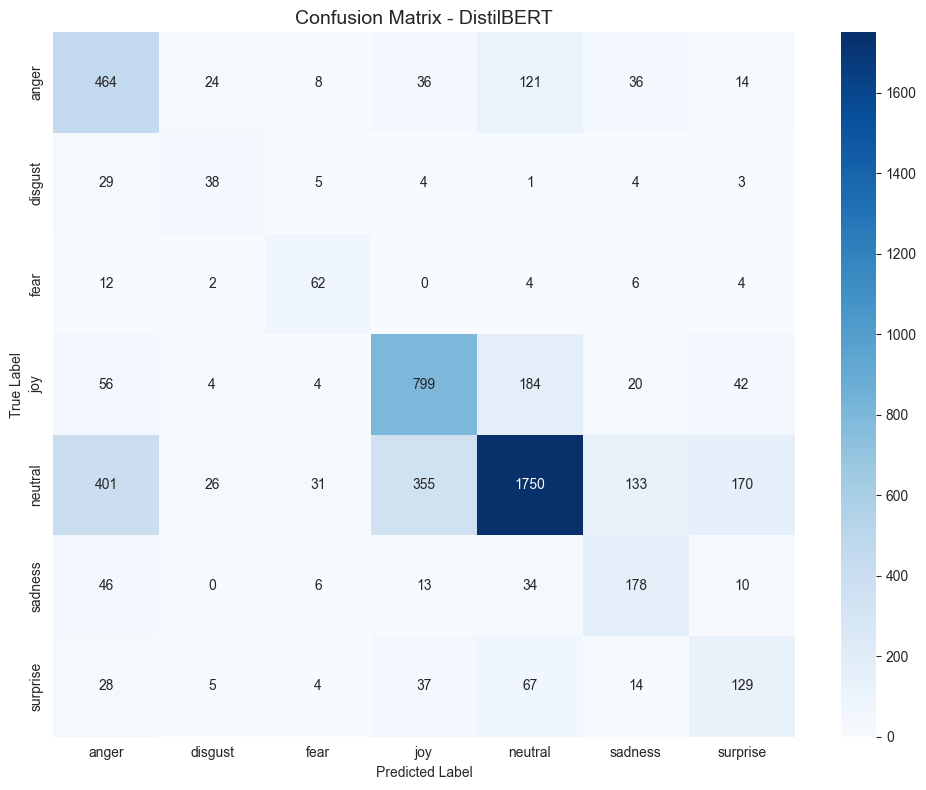

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=emotion_names,
            yticklabels=emotion_names)
plt.title("Confusion Matrix - DistilBERT", fontsize=14)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("../results/figures/confusion_matrix_distilbert.png", dpi=300, bbox_inches="tight")
plt.show()


Save Results

In [18]:
distilbert_results = {
    "accuracy": test_results["eval_accuracy"],
    "precision": test_results["eval_precision"],
    "recall": test_results["eval_recall"],
    "f1": test_results["eval_f1"]
}

results_df = pd.DataFrame([distilbert_results], index=["DistilBERT"])
results_df = results_df.round(4)

print("DistilBERT Performance on Test Set:")
print(results_df)

results_df.to_csv("../results/models/distilbert_results.csv")
print("\nResults saved to: ../results/models/distilbert_results.csv")


DistilBERT Performance on Test Set:
            accuracy  precision  recall      f1
DistilBERT    0.6306     0.6742  0.6306  0.6406

Results saved to: ../results/models/distilbert_results.csv


Summary

In [19]:
print("DistilBERT Training Summary:")
print(f"  Model: distilbert-base-uncased")
print(f"  Accuracy: {distilbert_results['accuracy']:.4f}")
print(f"  F1-Score: {distilbert_results['f1']:.4f}")
print(f"  Precision: {distilbert_results['precision']:.4f}")
print(f"  Recall: {distilbert_results['recall']:.4f}")
print(f"\nModel saved to: ../models/distilbert_emotion_model")


DistilBERT Training Summary:
  Model: distilbert-base-uncased
  Accuracy: 0.6306
  F1-Score: 0.6406
  Precision: 0.6742
  Recall: 0.6306

Model saved to: ../models/distilbert_emotion_model
